# Image-Based Computational Modeling and Analysis
### HW2
### Zane Bates

### Problem 1 (5 points) In image processing, boundary detection is the most critical step. Given a 2D image , how to detect boundaries of different regions?

### A: 
Boundary detection is done via various segmentation methods. While there is no generalized all-purpose boundary detection method, the gradient vector and gradient magnitude are widely used in these methods. Level set methods are very prominent in tracking moving boundaries and interfaces. It is a numerical method for computing surface deformations as time-varying isocontours of the intensity field by solving PDE's on a 3D grid of the object's volume. 

### Problem 2 (20 points) Implement the following linear and non-linear filters using the finite different method to smooth the image , and apply your code to the given 2D image (foot.pgm). Please output your results in .pgm format and visualize them using IrfanView or other software.

#### PDE Image Filtering (Linear & Nonlinear)

**What this notebook does**
- Loads a PGM (P2) image (e.g., `foot.pgm`).
-  **Linear diffusion** 
-  **Nonlinear diffusion**
- Shows intermediate results so you see the image evolve.

In [1]:

!python -m pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

np.set_printoptions(precision=3, suppress=True)


In [2]:

def read_pgm_p2(path):
    with open(path, 'r') as f:
        magic = f.readline().strip()
        if magic != 'P2':
            raise ValueError(f"Expected P2, got {magic}")
        def tokens():
            for line in f:
                line=line.strip()
                if not line or line.startswith('#'):
                    continue
                for t in line.split():
                    yield t
        tok = tokens()
        w = int(next(tok)); h = int(next(tok))
        maxv = int(next(tok))
        vals = [int(t) for t in tok]
        if len(vals) != w*h:
            raise ValueError(f"Expected {w*h} pixels, got {len(vals)}")
        img = np.array(vals, dtype=float).reshape(h, w)
        return img, maxv

def write_pgm_p2(path, img, maxv=255):
    img = np.clip(img, 0, maxv)
    h, w = img.shape
    with open(path, 'w') as f:
        f.write("P2\n")
        f.write(f"{w} {h}\n{int(maxv)}\n")
        flat = np.rint(img).astype(int).ravel()
        for i, v in enumerate(flat):
            f.write(str(v) + ("\n" if (i+1)%17==0 else " "))

# ---------- Linear and Nonlinear Diffusion Equation Functions ----------
def laplacian(u):
    p = np.pad(u, 1, mode='edge')
    return (p[2:,1:-1] + p[:-2,1:-1] + p[1:-1,2:] + p[1:-1,:-2] - 4*u)

def gradient_central(u):
    p = np.pad(u, 1, mode='edge')
    ux = (p[1:-1,2:] - p[1:-1,:-2]) * 0.5
    uy = (p[2:,1:-1] - p[:-2,1:-1]) * 0.5
    return ux, uy

def g_conductance(ux, uy, lam=10.0, kind="exp"):
    s = np.sqrt(ux*ux + uy*uy)
    if kind == "exp":
        return np.exp(-(s/lam)**2)
    else:
        raise ValueError("kind must be 'exp")

def divergence(gx, gy):
    px = np.pad(gx, 1, mode='edge')
    py = np.pad(gy, 1, mode='edge')
    dFx_dx = (px[1:-1,2:] - px[1:-1,:-2]) * 0.5
    dFy_dy = (py[2:,1:-1] - py[:-2,1:-1]) * 0.5
    return dFx_dx + dFy_dy

def linear(u, dt=0.2):
    return u + dt * laplacian(u)

def non_linear(u, dt=0.2, lam=10.0, kind="exp"):
    ux, uy = gradient_central(u)
    g = g_conductance(ux, uy, lam=lam, kind=kind)
    Fx = g * ux
    Fy = g * uy
    return u + dt * divergence(Fx, Fy)


Loaded: foot.pgm shape: (136, 149) maxv: 255


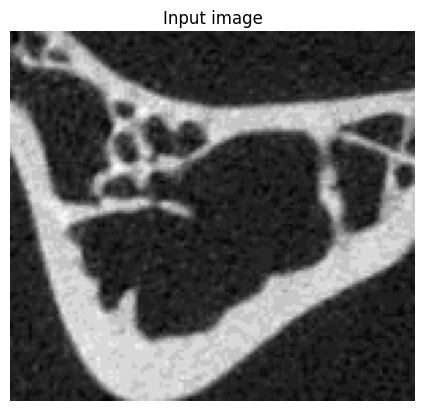

In [3]:

# --------- Load your image (PGM P2) ---------
img_path = Path("foot.pgm")  # change if needed
u0, maxv = read_pgm_p2(img_path)
print("Loaded:", img_path, "shape:", u0.shape, "maxv:", maxv)

plt.figure()
plt.title("Input image")
plt.imshow(u0, cmap="gray")
plt.axis("off")
plt.show()


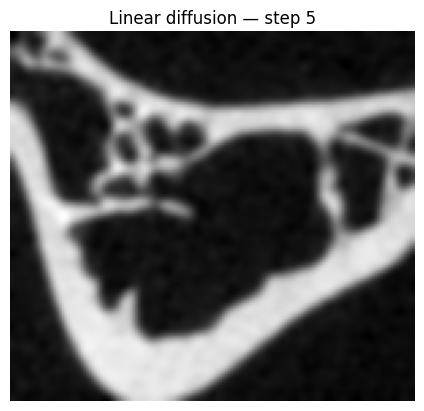

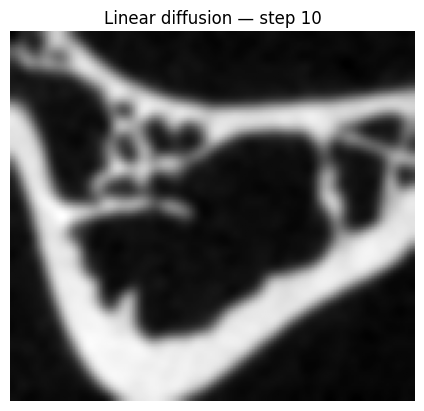

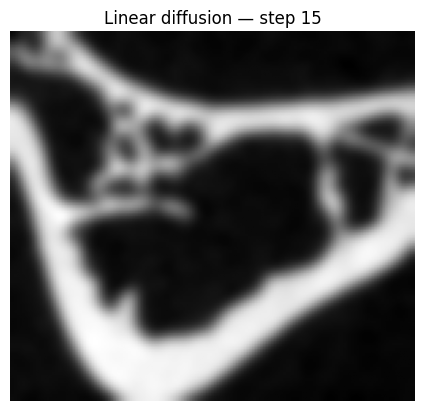

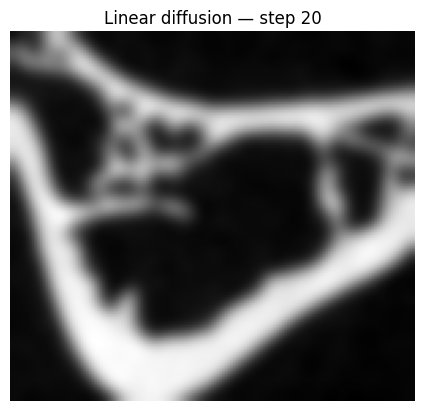

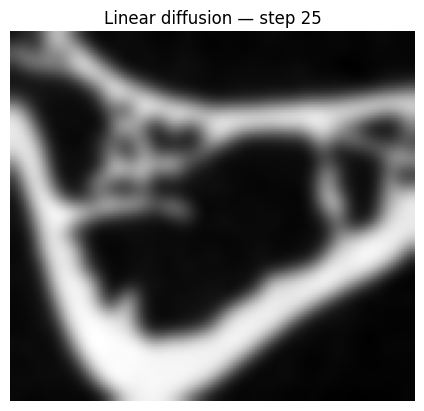

Saved: foot_linear_it25.pgm


In [4]:

# --------- Linear diffusion (heat equation) demo ---------
u = u0.copy()
dt = 0.2
iters = 25
show_every = 5

for k in range(1, iters+1):
    u = linear(u, dt=dt)
    if k % show_every == 0 or k == iters:
        plt.figure()
        plt.title(f"Linear diffusion — step {k}")
        plt.imshow(u, cmap="gray")
        plt.axis("off")
        plt.show()

out_lin = img_path.with_name(img_path.stem + f"_linear_it{iters}.pgm")
write_pgm_p2(out_lin, u, maxv=maxv)
print("Saved:", out_lin)


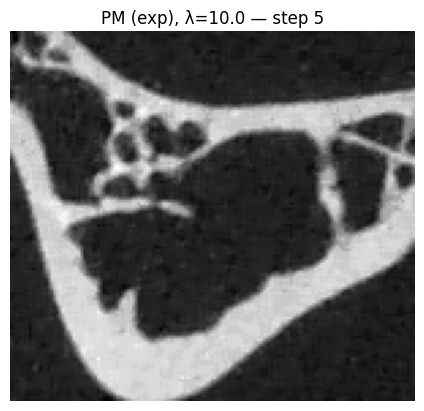

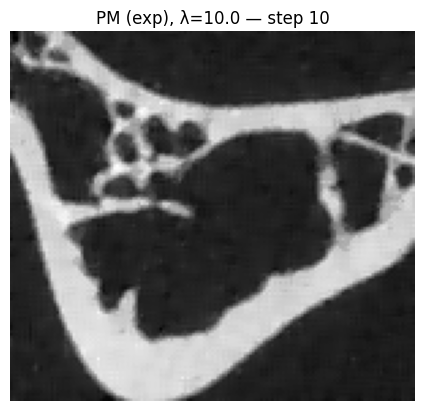

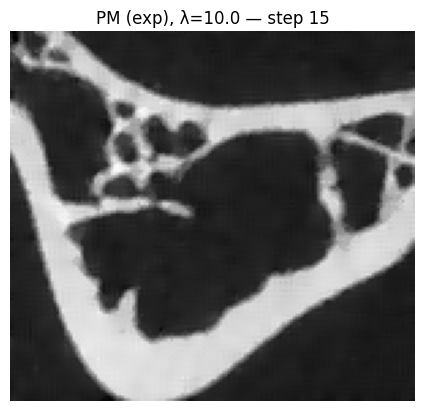

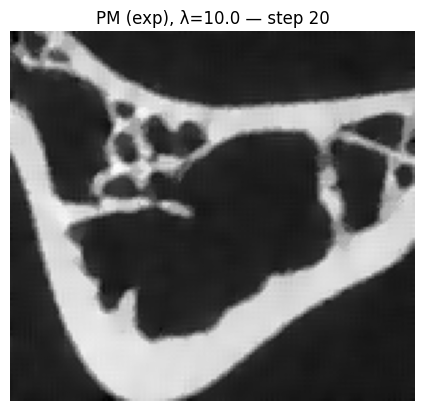

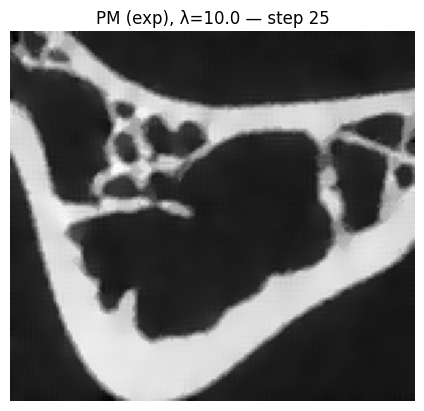

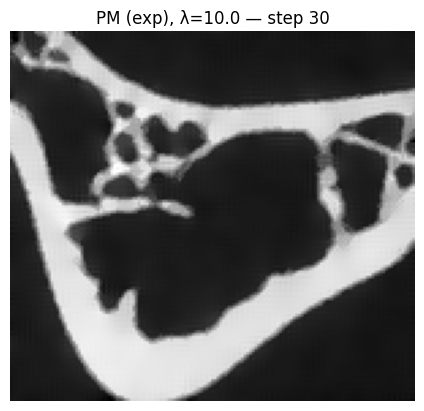

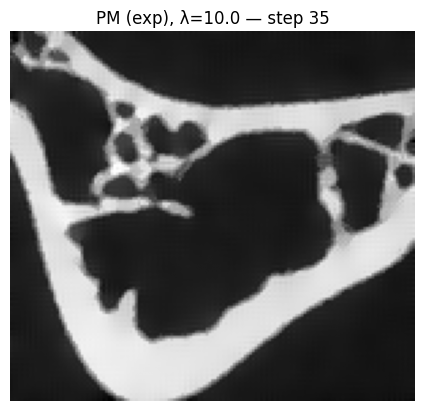

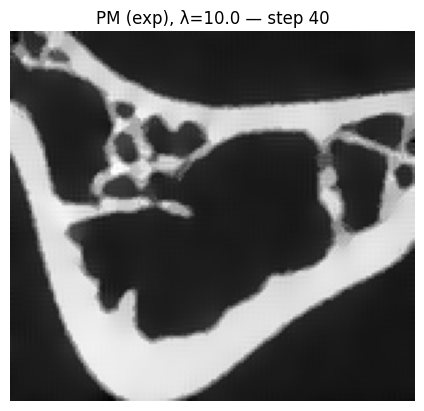

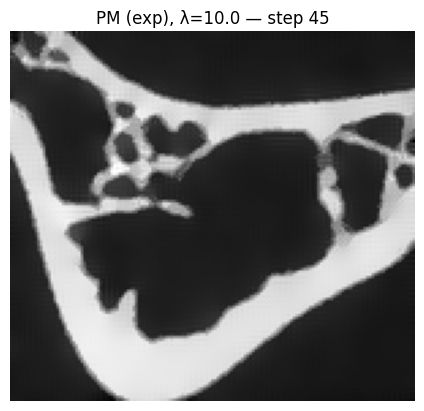

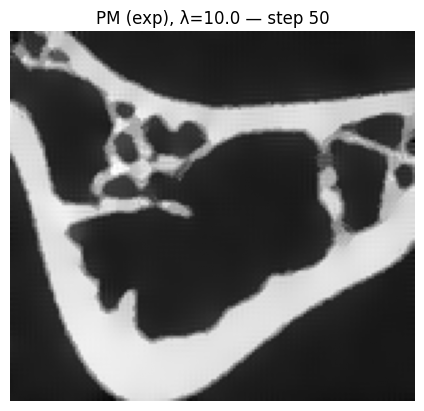

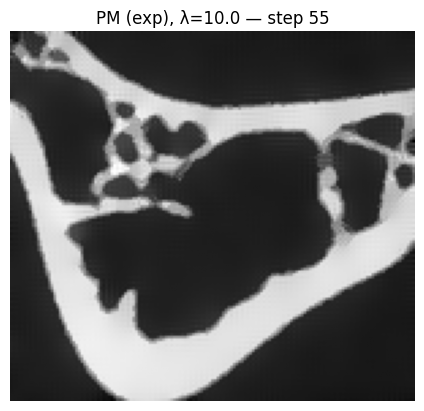

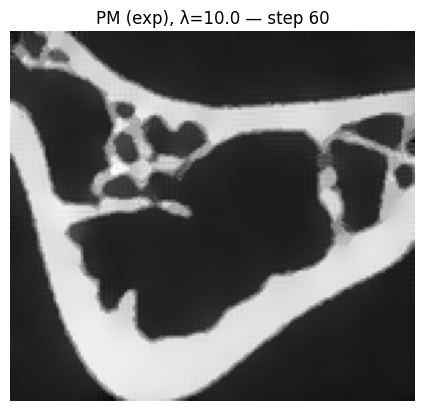

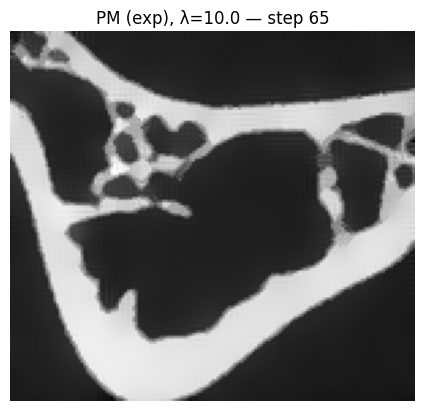

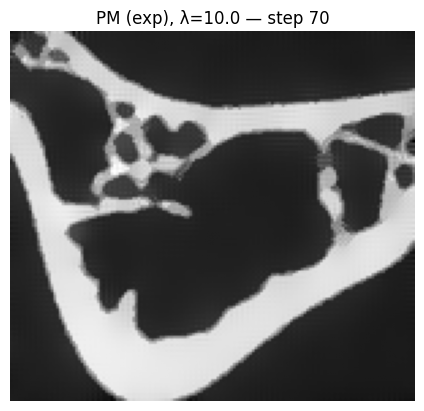

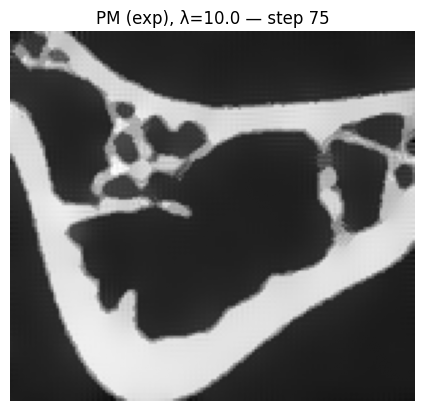

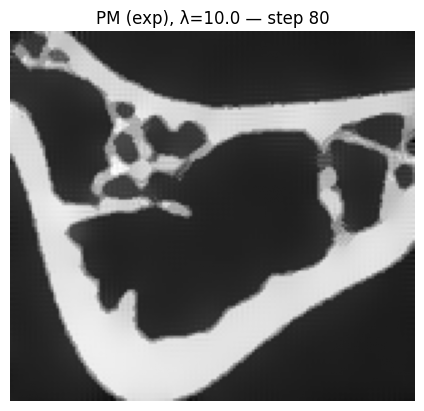

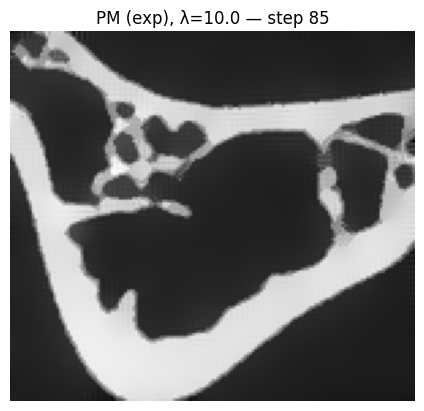

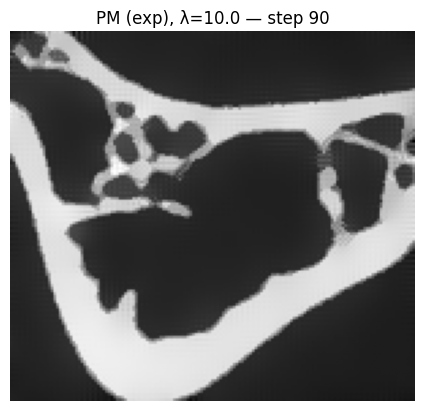

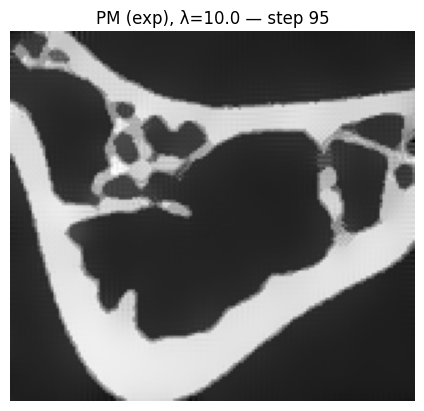

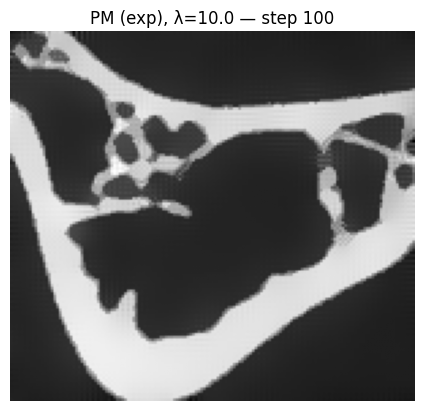

Saved: foot_nonlin_exp_lam10_it100.pgm


In [ ]:

# --------- Nonlinear diffusion demo ---------
u = u0.copy()
dt = 0.2
iters = 100
lam = 10.0
gkind = "exp"
show_every = 5

for k in range(1, iters+1):
    u = non_linear(u, dt=dt, lam=lam, kind=gkind)
    if k % show_every == 0 or k == iters:
        plt.figure()
        plt.title(f"PM ({gkind}), λ={lam} — step {k}")
        plt.imshow(u, cmap="gray")
        plt.axis("off")
        plt.show()

out_nonlin = img_path.with_name(img_path.stem + f"_nonlin_{gkind}_lam{int(lam)}_it{iters}.pgm")
write_pgm_p2(out_nonlin, u, maxv=maxv)
print("Saved:", out_nonlin)
